##  Information:

Dataset: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis

Team Members: Jon Dinh, Damani Thomas, Denzel Prudent

## Background: 
  Sentiment Analysis serves as a practical natural language processing technique in identifying and extracting user sentiment on certain topics based on user-generated data such as comments. The technique has gained popularity throughout the recent decades and new strategies and implementations have been developed to further improve Sentimental Analysis.
However, even though the technique is widely adoptive there still are challenges in interpreting the sentiment of a text. For example, the use of sarcasm, whether obvious or suggested, can skew the results of many sentiment analysis systems that can result in a misreading of a user’s sentiment. Other cases such as various languages being used sparingly in English text (such as the French phrase déja vu), and the use of ambiguity in a comment.

## Specific Project Problem:
  Working with the IMDB Movie Ratings Sentiment Analysis Dataset. The corpus contains approximately 40,000 labeled observations. Each observation is a separate review, and contains a label of zero for negative sentiment and one for positive sentiment. Our motivation is the successful implementation of the basic topics covered in the course towards predicting the polarity or external sentiment of movie reviews.

## Strategy:
  - read in data (done)
  - cleaning (done)
  - extraction (BoW, TFIDF, DTM) (done -> as a pipeline step)
  - split dataset into training/validation/test (done)
  - Model creation (NB, logistic, SVM, KMeans) (done)
  - choose choose best model (done)
  - GridSearchCV with models to determine optimal parameters
  - Try: compare with Pattern, VADER, spaCY sentiment packages (done with Pattern)
   - https://www.unite.ai/10-best-python-libraries-for-sentiment-analysis/ 
  - NOTE: if time, try other variation of extraction, or LSTM

## Evaluation:
- based off ZeroR (labeled majority class) (done)
- confusion matrix (done)
- TP, FP, precision (PPV), recall (TPR), f-measure, specificity (TNR) (done)
- cross-validation score (not yet. Maybe add to eval step?)
- LimeTextExplainer (do once primary model chosen and tuned)

## Settings and Imports

In [ ]:
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for shap: filename=shap-0.39.0-cp310-cp310-linux_x86_64.whl size=535078 sha256=2f99061a36d6d6c2f1fd063406931c2bb1dd65c81ecda05ffe82790d38dbb000
  Stored in directory: /root/.cache/pip/wheels/d4/ef/8d/78a07e01b86b1a0363626186f072e01683c10335e2eb89e337
Successfully built shap


In [ ]:
#!pip install "PACKAGE" -> command to download packages into colab

# data handling
from google.colab import files
import numpy as np
import pandas as pd
import random
from collections import Counter
from sklearn.pipeline import Pipeline
from collections import defaultdict
import operator
# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, MaxAbsScaler
import re

# cleaning & preprocessing
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import shap

# models
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# settings
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# paths and persistents
DATAPATH = 'movie.csv'
clear_output()

# Helper Functions

In [ ]:
def clean(data): 
    """
    input: string type of line/paragraph
    process: lowercase, remove punctuation, split,
      remove STOPWORDS, remove words with less than or equal to two letters
    output: return a single cleaned string 
    """
    # NOTE: These are just helper functions, TfidfVectorizer already;
    # lowers, removes punctuation, removes stop words, removes len < 2.
    # May choose to apply this before and after anyways, there should be no difference. 
    lines = data.lower()
    lines = re.sub('[^A-Za-z]+', ' ', lines) 
    tokens = lines.split() 
    clean_tokens = [word for word in tokens if word not in STOPWORDS] 
    clean_tokens = [word for word in clean_tokens if len(word) > 2]
    clean_string = ' '.join(map(str, clean_tokens)) 
    return clean_string

In [ ]:
def visualize_explain(idx, x_test, y_test, shap_values, prediction, explainer, vectorizer):
    """
    # Initialize the explainer and apply to test data
    masker = shap.maskers.Independent(data = x_train)
    explainer = shap.LinearExplainer(model, masker = masker)
    shap_values = explainer.shap_values(x_test)
    """
    X_test_array = x_test.toarray() # condense array
    shap.initjs()
    print('Actual: ', y_test[idx])
    print('Predicted: ',prediction[idx])
    display(shap.force_plot(
        explainer.expected_value, 
        shap_values[idx,:], 
        X_test_array[idx,:],
        feature_names=vectorizer.get_feature_names_out()))


In [ ]:
def feature_explain(idx, shap_values, vectorizer, pr = True):
    vals = shap_values[idx,:]
    positive_sentiment_weight = defaultdict(float)
    negative_sentiment_weight = defaultdict(float)
    feats = vectorizer.get_feature_names_out()
    for feat_i, val_i in zip(feats, vals):
      if val_i > 0:
        positive_sentiment_weight[feat_i] += val_i
      elif val_i < 0:
        negative_sentiment_weight[feat_i] += val_i
    lp = list(sorted(positive_sentiment_weight.items(), key=operator.itemgetter(1), reverse=True))[:10]
    ln = list(sorted(negative_sentiment_weight.items(), key=operator.itemgetter(1)))[:10]
    if pr:
      print(lp)
      print(ln)
    return positive_sentiment_weight, negative_sentiment_weight # returns dict of word:weight

# Data Cleaning

In [ ]:
data = pd.read_csv(DATAPATH)

In [ ]:
# cleaning the text feature
data.text = data.text.apply(clean)

In [ ]:
# check for NULL and duplicated entries
print('Number of NULL entries: ', data.isnull().sum().sum())
print('Number of duplicated observations: ', data.duplicated().sum())

# remove duplicated entries
data.drop_duplicates(inplace = True)
print('Number of duplicated observations after dropping: ',data.duplicated().sum() )

# print shape
print('Row/Columns: ', data.shape)
# view data
data.head()

Number of NULL entries:  0
Number of duplicated observations:  281
Number of duplicated observations after dropping:  0
Row/Columns:  (39719, 2)


,text,label
0,grew watching loving thunderbirds mates school...,0
1,put movie dvd player sat coke chips expectatio...,0
2,people know particular time past feel need try...,0
3,even though great interest biblical movies bor...,0
4,die hard dads army fan nothing will change got...,1


# EDA

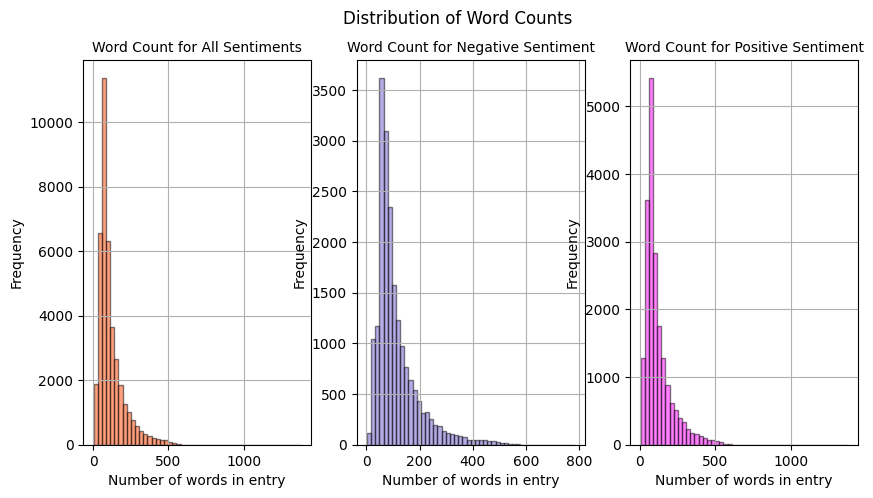

In [ ]:
# visualize distribution of count of words
fig, ax = plt.subplots(1, 3, figsize = (10,5))
data['count']=data['text'].apply(lambda x:len(x.split()))
fig.suptitle('Distribution of Word Counts')

ax[0].hist(data['count'], bins = 50, alpha = .5, histtype = 'bar', ec = 'black', color = 'orangered')
ax[0].set_title('Word Count for All Sentiments',fontsize=10)
ax[0].set_xlabel('Number of words in entry')
ax[0].set_ylabel('Frequency')
ax[0].grid()

ax[1].hist(data[data['label']==0]['count'], bins = 50, alpha = .5, histtype = 'bar', ec = 'black', color = 'slateblue')
ax[1].set_title('Word Count for Negative Sentiment',fontsize=10)
ax[1].set_xlabel('Number of words in entry')
ax[1].set_ylabel('Frequency')
ax[1].grid()

ax[2].hist(data[data['label']==1]['count'], bins = 50, alpha = .5, histtype = 'bar', ec = 'black', color = 'magenta')
ax[2].set_title('Word Count for Positive Sentiment',fontsize=10)
ax[2].set_xlabel('Number of words in entry')
ax[2].set_ylabel('Frequency')
ax[2].grid()

plt.show()

Number of Positive Sentiment Reviews:  19907
Number of Negative Sentiment Reviews:  19812


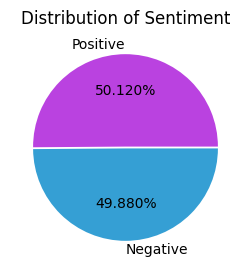

In [ ]:
# visualize label ratio or distribution
print('Number of Positive Sentiment Reviews: ', data[data['label'] == 1].label.shape[0])
print('Number of Negative Sentiment Reviews: ', data[data['label'] == 0].label.shape[0])

plt.figure(figsize = (3,3))
plt.pie(data.label.value_counts(), labels = ['Positive', 'Negative'], autopct = '%.3f%%', explode = [.01, .01], colors = ['#BA42E0','#359FD4']);
plt.title('Distribution of Sentiment');

# Preprocesing: Roughly 80% train, 10% development, 10% test
- x_train = train features
- y_train = train labels
- x_dev = dev features
- y_dev = dev labels
- x_test = test features
- y_test = test labels


In [ ]:
# from entire corpus -> split into test and train/dev
x_train, x_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size = 0.10, stratify=data['label'], random_state = 1)

# from train/dev corpus -> split into train and dev
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size = 0.11, stratify=y_train, random_state = 1)

# print set shapes
print('Train feature shape: ', x_train.shape)
print('Train label shape  : ', y_train.shape)
print('Dev feature shape  : ', x_dev.shape)
print('Dev label shape    : ', y_dev.shape)
print('Test feature shape : ', x_test.shape)
print('Test label shape   : ', y_test.shape)

Train feature shape:  (31814,)
Train label shape  :  (31814,)
Dev feature shape  :  (3933,)
Dev label shape    :  (3933,)
Test feature shape :  (3972,)
Test label shape   :  (3972,)


# Model Creation, Prediction and Evaluation

In [ ]:
def eval(x_train, y_train, x_test, y_test, prediction = None, model = True, pipe = None):
    if model:
        # fit and predict
        pipe.fit(x_train, y_train)

        # predict
        prediction = pipe.predict(x_test)
    # obtain performance metrics
    acc = accuracy_score(y_test, prediction)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, prediction, average = 'weighted')
    cm = confusion_matrix(y_test,prediction)
    roc_acc = roc_auc_score(y_test, prediction)
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    # cross_val_score(estimator, X, y=None) # estimator needs fit() and predict() method
    # create res object
    results={'accuracy':acc,
             'precision':precision,
             'recall':recall,
             'f1_score':fscore, 
             'TN': cm[0][0],
             'FP': cm[0][1],
             'FN': cm[1][0],
             'TP': cm[1][1],
             'roc_acc':roc_acc,
             'FPR': cm[0][1] / (cm[0][1] + cm[0][0]),
             'TPR': cm[1][1] / (cm[1][1] + cm[1][0]),
             'TNR': cm[0][0] / (cm[0][0] + cm[0][1]),
             'FNR': cm[1][0] / (cm[1][0] + cm[1][1])}

    # plot the confusion matrix
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    colors = ['#ECA1A6','#D4333C']
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.subplots(figsize = (3,3));
    sns.heatmap(cm,annot = labels,cmap = colors,fmt ='')
    
    return results

def store_res(exp_result,exp_name,overall_result=pd.DataFrame()):

    df=pd.DataFrame(exp_result,index=[exp_name])
    return pd.concat([overall_result,df],axis=0)

# Baseline

,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.5,1.0,1.0,0.0,0.0


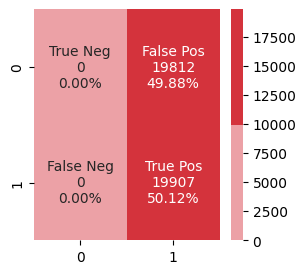

In [ ]:
data['ZeroR'] = [1 for i in range(data.shape[0])]
# baseline, label all predictions as majority class (positive)
pipeline0_res = eval(data['ZeroR'], data['label'], data['ZeroR'], data['label'], prediction = data['ZeroR'], model = False, pipe = None)
df_dev = store_res(pipeline0_res, 'ZeroR (Baseline)')
df_dev

In [ ]:
# Compare to Pattern package using polarity() function -> returns int in [-1, 1] 
!pip install -U pattern
from pattern.en import sentiment, polarity, subjectivity, positive
clear_output()

In [ ]:
# get polarity of all examples
senti = []
# set threshold to 0.1 polarity on scale [-1, 1]
for i in range(data.shape[0]):
  res = polarity(data.iloc[i, 0])
  if res >= 0.1:
    senti.append(1)
  else:
    senti.append(0)

,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.500000,1.000000,1.000000,0.000000,0.000000
Pattern-Polarity(0.1),0.764244,0.764322,0.764244,0.764233,15290,4522,4842,15065,0.764262,0.228246,0.756769,0.771754,0.243231


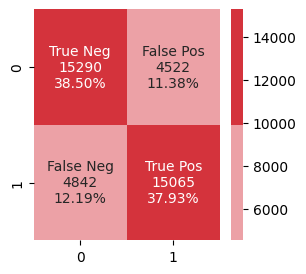

In [ ]:
data['pattern_polarity'] = senti
# realize that there is no need to model, simply comparing polarity threshold with true label
pipeline8_res = eval(data['pattern_polarity'], data['label'], data['pattern_polarity'], data['label'], prediction = data['pattern_polarity'], model = False, pipe = None)
df_dev = store_res(pipeline8_res, 'Pattern-Polarity(0.1)', overall_result=df_dev)
df_dev

# Models

,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.500000,1.000000,1.000000,0.000000,0.000000
Pattern-Polarity(0.1),0.764244,0.764322,0.764244,0.764233,15290,4522,4842,15065,0.764262,0.228246,0.756769,0.771754,0.243231
NB-TFIDF,0.872362,0.872766,0.872362,0.872333,1743,219,283,1688,0.872399,0.111621,0.856418,0.888379,0.143582


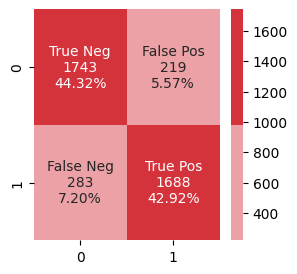

In [ ]:
# creating NB Classifier
# Params: alpha=1.0, fit_prior=True 
pipeline1 = Pipeline([('tfidf', TfidfVectorizer(stop_words = list(STOPWORDS))), ('NBClassifier', MultinomialNB())])
# fit, predict, score, show results
pipeline1_res = eval(x_train, y_train, x_dev, y_dev, pipe = pipeline1)
# save the results
df_dev = store_res(pipeline1_res, 'NB-TFIDF', overall_result=df_dev)
df_dev

,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.500000,1.000000,1.000000,0.000000,0.000000
Pattern-Polarity(0.1),0.764244,0.764322,0.764244,0.764233,15290,4522,4842,15065,0.764262,0.228246,0.756769,0.771754,0.243231
NB-TFIDF,0.872362,0.872766,0.872362,0.872333,1743,219,283,1688,0.872399,0.111621,0.856418,0.888379,0.143582
Logistic-TFIDF,0.898805,0.898965,0.898805,0.898792,1743,219,179,1792,0.898781,0.111621,0.909183,0.888379,0.090817


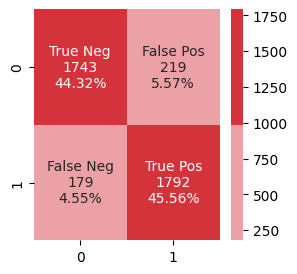

In [ ]:
# creating logistic regression model
# penalty{‘l1’, ‘l2’, ‘elasticnet’, None}, C, solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}
pipeline2 = Pipeline([('tfidf', TfidfVectorizer(stop_words = list(STOPWORDS))), ('Logistic', LogisticRegression(random_state = 1))])
# fit, predict, score, show results
pipeline2_res = eval(x_train, y_train, x_dev, y_dev, pipe = pipeline2)
# save the results
df_dev = store_res(pipeline2_res, 'Logistic-TFIDF', overall_result = df_dev)
df_dev

,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.500000,1.000000,1.000000,0.000000,0.000000
Pattern-Polarity(0.1),0.764244,0.764322,0.764244,0.764233,15290,4522,4842,15065,0.764262,0.228246,0.756769,0.771754,0.243231
NB-TFIDF,0.872362,0.872766,0.872362,0.872333,1743,219,283,1688,0.872399,0.111621,0.856418,0.888379,0.143582
Logistic-TFIDF,0.898805,0.898965,0.898805,0.898792,1743,219,179,1792,0.898781,0.111621,0.909183,0.888379,0.090817
SVM-Linear-TFIDF,0.895500,0.895534,0.895500,0.895496,1747,215,196,1775,0.895488,0.109582,0.900558,0.890418,0.099442


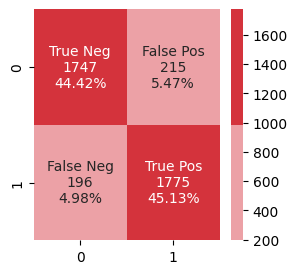

In [ ]:
"""
NOTE: DON'T RUN THIS AGAIN. TAKES LIKES 20 MIN TO RUN BECAUSE THE DATA IS SO 
SPARSE. SINCE TFIDF USES FEATURES = VOCAB SET, WE CAN'T REALLY REDUCE THE SAMPLE,
BECAUSE WE CAN'T GUARANTEE ALL VOCAB WILL BE PRESENT FOR TRAINING. ALSO,
SVMs DO NOT SCALE WELL WITH HIGH DIMENSIONAL DATA (40,000 rows). RUNTIME IS
O(n^2) to O(n^3) with n = 40,000. SO 1,600,000,000 to 64,000,000,000,000 iterations. 
"""
# creating SVM kernel
# params = {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
pipeline3 = Pipeline([('tfidf', TfidfVectorizer(stop_words = list(STOPWORDS))), ('SVM-Linear', SVC(kernel ='linear'))])
# fit, predict, score, show results
pipeline3_res = eval(x_train, y_train, x_dev, y_dev, pipe = pipeline3)
# save the results
df_dev = store_res(pipeline3_res, 'SVM-Linear-TFIDF', overall_result=df_dev)
df_dev

,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.500000,1.000000,1.000000,0.000000,0.000000
Pattern-Polarity(0.1),0.764244,0.764322,0.764244,0.764233,15290,4522,4842,15065,0.764262,0.228246,0.756769,0.771754,0.243231
NB-TFIDF,0.872362,0.872766,0.872362,0.872333,1743,219,283,1688,0.872399,0.111621,0.856418,0.888379,0.143582
Logistic-TFIDF,0.898805,0.898965,0.898805,0.898792,1743,219,179,1792,0.898781,0.111621,0.909183,0.888379,0.090817
SVM-Linear-TFIDF,0.895500,0.895534,0.895500,0.895496,1747,215,196,1775,0.895488,0.109582,0.900558,0.890418,0.099442
KNN-TFIDF,0.778286,0.785024,0.778286,0.776914,1374,588,284,1687,0.778108,0.299694,0.855911,0.700306,0.144089


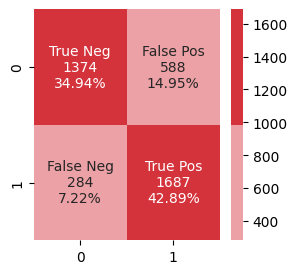

In [ ]:
"""
DO NOT RUN THIS AGAIN. KNN is O(nd) = O(40,000 * 3031374 = 121,254,960,000)
"""
# creating KMEANS model
# params = n_neighbors, algorithm
pipeline4 = Pipeline([('tfidf', TfidfVectorizer(stop_words = list(STOPWORDS))), ('KNN', KNeighborsClassifier())])
# fit, predict, score, show results
pipeline4_res = eval(x_train, y_train, x_dev, y_dev, pipe = pipeline4)
# save the results
df_dev = store_res(pipeline4_res, 'KNN-TFIDF', overall_result=df_dev)
df_dev

,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.500000,1.000000,1.000000,0.000000,0.000000
Pattern-Polarity(0.1),0.764244,0.764322,0.764244,0.764233,15290,4522,4842,15065,0.764262,0.228246,0.756769,0.771754,0.243231
NB-TFIDF,0.872362,0.872766,0.872362,0.872333,1743,219,283,1688,0.872399,0.111621,0.856418,0.888379,0.143582
Logistic-TFIDF,0.898805,0.898965,0.898805,0.898792,1743,219,179,1792,0.898781,0.111621,0.909183,0.888379,0.090817
SVM-Linear-TFIDF,0.895500,0.895534,0.895500,0.895496,1747,215,196,1775,0.895488,0.109582,0.900558,0.890418,0.099442
KNN-TFIDF,0.778286,0.785024,0.778286,0.776914,1374,588,284,1687,0.778108,0.299694,0.855911,0.700306,0.144089
DecisionTree-TFIDF,0.725400,0.725479,0.725400,0.725385,1439,523,557,1414,0.725419,0.266565,0.717402,0.733435,0.282598


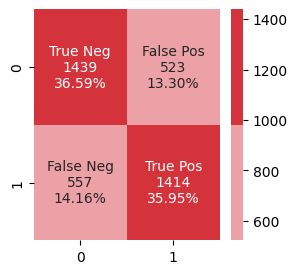

In [ ]:
# creating DecisionTreeClassifer
# params = criterion, max_depth, min_samples, min_samples_leaf
pipeline5 = Pipeline([('tfidf', TfidfVectorizer(stop_words = list(STOPWORDS))), ('DecisionTree', DecisionTreeClassifier())])
# fit, predict, score, show results
pipeline5_res = eval(x_train, y_train, x_dev, y_dev, pipe = pipeline5)
# save the results
df_dev = store_res(pipeline5_res, 'DecisionTree-TFIDF', overall_result=df_dev)
df_dev

,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.500000,1.000000,1.000000,0.000000,0.000000
Pattern-Polarity(0.1),0.764244,0.764322,0.764244,0.764233,15290,4522,4842,15065,0.764262,0.228246,0.756769,0.771754,0.243231
NB-TFIDF,0.872362,0.872766,0.872362,0.872333,1743,219,283,1688,0.872399,0.111621,0.856418,0.888379,0.143582
Logistic-TFIDF,0.898805,0.898965,0.898805,0.898792,1743,219,179,1792,0.898781,0.111621,0.909183,0.888379,0.090817
SVM-Linear-TFIDF,0.895500,0.895534,0.895500,0.895496,1747,215,196,1775,0.895488,0.109582,0.900558,0.890418,0.099442
KNN-TFIDF,0.778286,0.785024,0.778286,0.776914,1374,588,284,1687,0.778108,0.299694,0.855911,0.700306,0.144089
DecisionTree-TFIDF,0.725400,0.725479,0.725400,0.725385,1439,523,557,1414,0.725419,0.266565,0.717402,0.733435,0.282598
RF-TFIDF,0.858886,0.859082,0.858886,0.858872,1707,255,300,1671,0.858912,0.129969,0.847793,0.870031,0.152207


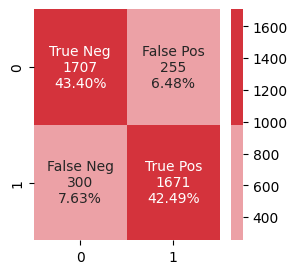

In [ ]:
# creating RandomForest
pipeline6 = Pipeline([('tfidf', TfidfVectorizer(stop_words = list(STOPWORDS))), ('DecisionTree', RandomForestClassifier())])
# fit, predict, score, show results
pipeline6_res = eval(x_train, y_train, x_dev, y_dev, pipe = pipeline6)
# save the results
df_dev = store_res(pipeline6_res, 'RF-TFIDF', overall_result=df_dev)
df_dev

,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.500000,1.000000,1.000000,0.000000,0.000000
Pattern-Polarity(0.1),0.764244,0.764322,0.764244,0.764233,15290,4522,4842,15065,0.764262,0.228246,0.756769,0.771754,0.243231
NB-TFIDF,0.872362,0.872766,0.872362,0.872333,1743,219,283,1688,0.872399,0.111621,0.856418,0.888379,0.143582
Logistic-TFIDF,0.898805,0.898965,0.898805,0.898792,1743,219,179,1792,0.898781,0.111621,0.909183,0.888379,0.090817
SVM-Linear-TFIDF,0.895500,0.895534,0.895500,0.895496,1747,215,196,1775,0.895488,0.109582,0.900558,0.890418,0.099442
KNN-TFIDF,0.778286,0.785024,0.778286,0.776914,1374,588,284,1687,0.778108,0.299694,0.855911,0.700306,0.144089
DecisionTree-TFIDF,0.725400,0.725479,0.725400,0.725385,1439,523,557,1414,0.725419,0.266565,0.717402,0.733435,0.282598
RF-TFIDF,0.858886,0.859082,0.858886,0.858872,1707,255,300,1671,0.858912,0.129969,0.847793,0.870031,0.152207
XGB-TFIDF,0.861683,0.861928,0.861683,0.861655,1664,298,246,1725,0.861652,0.151886,0.875190,0.848114,0.124810


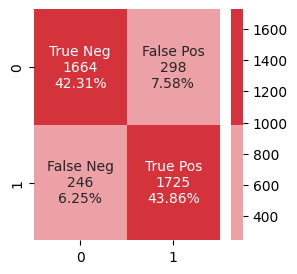

In [ ]:
# creating XGBoost with default "gbtree"
pipeline7 = Pipeline([('tfidf', TfidfVectorizer(stop_words = list(STOPWORDS))), ('XGBClassifier', XGBClassifier())])
# fit, predict, score, show results
pipeline7_res = eval(x_train, y_train, x_dev, y_dev, pipe = pipeline7)
# save the results
df_dev = store_res(pipeline7_res, 'XGB-TFIDF', overall_result=df_dev)
df_dev

In [ ]:
"""
mlpc = MLPClassifier(hidden_layer_sizes=(10, 10), 
             activation='relu', 
             solver='sgd', 
             alpha= 0.0001, 
             batch_size='auto', 
             learning_rate='adaptive', 
             learning_rate_init=0.001, 
             max_iter=1000, 
             shuffle=True, 
             random_state=1,  
             verbose=True, 
             warm_start=True, 
             momentum=0.9, 
)

# create pipe
pipeline8 = Pipeline([('tfidf', TfidfVectorizer(stop_words = list(STOPWORDS))), ('MLPC', mlpr)])
# fit, predict, score, show results
pipeline8_res = eval(x_train, y_train, x_dev, y_dev, pipe = pipeline8)
# save the results
df_dev = store_res(pipeline8_res, 'MLPC', overall_result=df_dev)
df_dev
"""
clear_output()

#  Feature Selection using SHAP
- find all misclassified reviews
- if actual = 1 and predicted = 0
 - get words that contributed to 0
- if actual = 0 and predicted = 1
  - get words that contributed to 1
- for every word
  - get the count of how many misclassified documents they are in
  - get the sum of absolute weights the word in all misclassed reviews

In [ ]:
# lets see what contributed to misclassification of reviews
vectorizer = pipeline2.named_steps['tfidf']
x_train2 = vectorizer.transform(x_train)
y_train2 = np.copy(y_train)
x_dev2  = vectorizer.transform(x_dev)
y_dev2  = np.copy(y_dev)

masker = shap.maskers.Independent(data = x_train2)
explainer = shap.Explainer(pipeline2.named_steps['Logistic'], masker = masker)
shap_values = explainer.shap_values(x_dev2)


In [ ]:
prediction = pipeline2.named_steps['Logistic'].predict(x_dev2)

In [ ]:
mis_id = [i for i in range(len(prediction)) if prediction[i] != list(y_dev2)[i]]

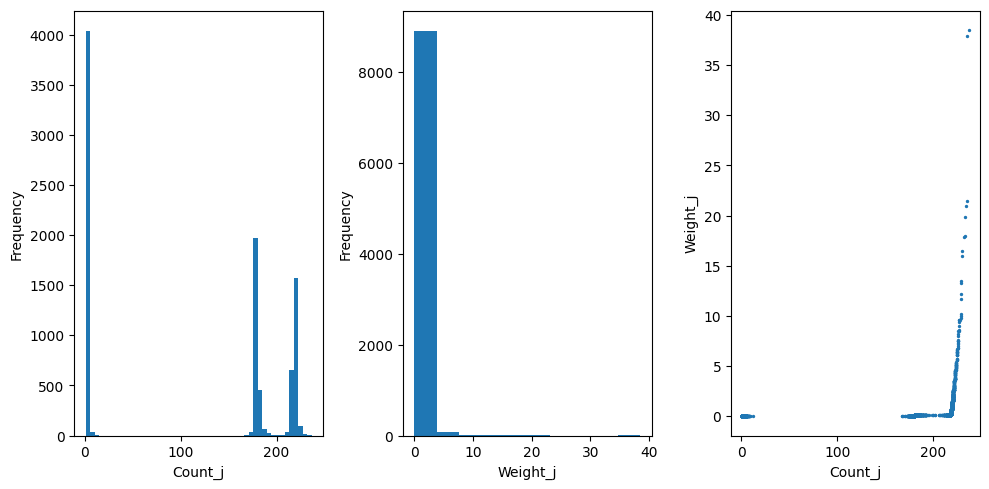

In [ ]:
# Create dictionaries 
word_count = {} # word:count
word_weight = {} # word:weight
25
# for misclassified id, get word and weights, classify Type I or II error
# get associated p_dict, n_dict from error type, add to count and weight dicts
for idx in mis_id:
    p, n = feature_explain(idx, shap_values, vectorizer, pr = False)
    if prediction[idx] == 0:
        for word in n:
          if word in word_count:
            word_count[word] += 1 
            word_weight[word] += abs(n[word])
          else:
            word_count[word] = 1
            word_weight[word] = abs(n[word])
    else:
        for word in p:
          if word in word_count:
            word_count[word] +=1 
            word_weight[word] += abs(p[word])
          else:
            word_count[word] = 1
            word_weight[word] = abs(p[word])
c = sorted([x for x in word_count.values()])
w = sorted([x for x in word_weight.values()])

fig, ax = plt.subplots(nrows = 1, ncols =3, figsize = (10, 5));

# Plot the distribution of count_j
ax[0].hist(c, bins = 50);
ax[0].set_xlabel('Count_j')
ax[0].set_ylabel('Frequency')

# plot distribution of weight_j
ax[1].hist(w);
ax[1].set_xlabel('Weight_j')
ax[1].set_ylabel('Frequency')

# plot scatter of count vs weight
ax[2].scatter(c, w, s = 2);
ax[2].set_xlabel('Count_j')
ax[2].set_ylabel('Weight_j')

plt.tight_layout()

Here we see that the disttribution of count_j of words that contribute to misclassification are heavily located on the left and lateral limits.

The sum of absolute weight of words that contribute to misclassifcation is heavily located on the lower end of the distribution as expected.

From the third plot, we see that most of the heavier weights that contribute to misclassification happen from words that occurred in over 220 documents that were misclassified. 

In [ ]:
top_10_count = sorted(word_count.items(), key = lambda kv: kv[1], reverse=True)[:10]
top_10_weight = sorted(word_weight.items(), key = lambda kv: kv[1], reverse=True)[:10]
print('Top Ten Words that appeared the most in misclassfied reviews: ',top_10_count)
print('Top ten words with highest sum of absolute weights in misclassified documents: ', top_10_weight)

Top Ten Words that appeared the most in misclassfied reviews:  [('don', 237), ('watching', 235), ('even', 235), ('nothing', 234), ('bad', 233), ('minutes', 233), ('look', 232), ('didn', 230), ('rest', 230), ('acting', 229)]
Top ten words with highest sum of absolute weights in misclassified documents:  [('bad', 38.49522417285132), ('great', 37.88955205978059), ('best', 21.44658311147895), ('even', 20.945161534182613), ('love', 19.82757141664325), ('worst', 17.94871757046271), ('well', 17.874281675494352), ('nothing', 16.446189630795462), ('boring', 16.016239802471343), ('awful', 13.505623991193866)]


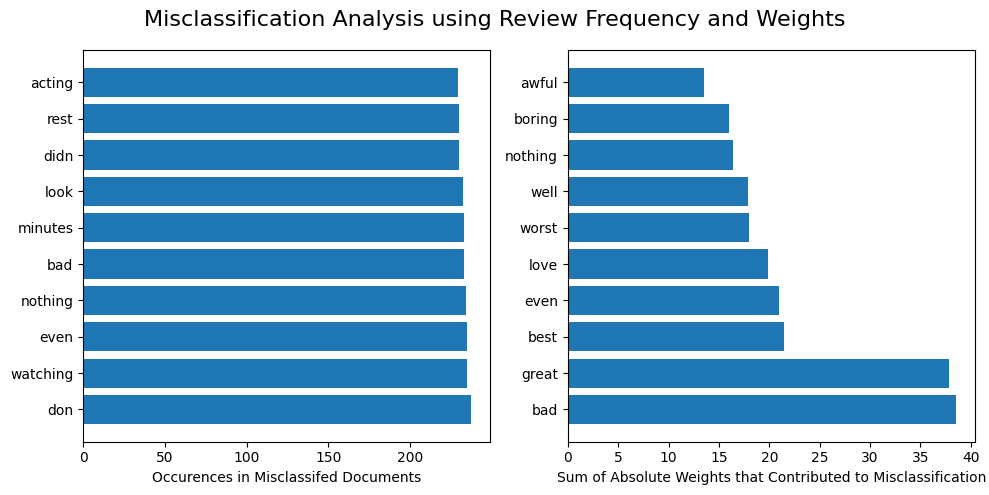

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
fig.suptitle('Misclassification Analysis using Review Frequency and Weights', fontsize=16)

ax[0].barh([x[0] for x in top_10_count], [x[1] for x in top_10_count])
ax[0].set_xlabel('Occurences in Misclassifed Documents')
ax[1].barh([x[0] for x in top_10_weight], [x[1] for x in top_10_weight])
ax[1].set_xlabel('Sum of Absolute Weights that Contributed to Misclassification')

plt.tight_layout()

Length of original vocab set:  82316
Length of vocab set to drop:  54
Length of modified vocab set:  82262


,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.500000,1.000000,1.000000,0.000000,0.000000
Pattern-Polarity(0.1),0.764244,0.764322,0.764244,0.764233,15290,4522,4842,15065,0.764262,0.228246,0.756769,0.771754,0.243231
NB-TFIDF,0.872362,0.872766,0.872362,0.872333,1743,219,283,1688,0.872399,0.111621,0.856418,0.888379,0.143582
Logistic-TFIDF,0.898805,0.898965,0.898805,0.898792,1743,219,179,1792,0.898781,0.111621,0.909183,0.888379,0.090817
SVM-Linear-TFIDF,0.895500,0.895534,0.895500,0.895496,1747,215,196,1775,0.895488,0.109582,0.900558,0.890418,0.099442
KNN-TFIDF,0.778286,0.785024,0.778286,0.776914,1374,588,284,1687,0.778108,0.299694,0.855911,0.700306,0.144089
DecisionTree-TFIDF,0.725400,0.725479,0.725400,0.725385,1439,523,557,1414,0.725419,0.266565,0.717402,0.733435,0.282598
RF-TFIDF,0.858886,0.859082,0.858886,0.858872,1707,255,300,1671,0.858912,0.129969,0.847793,0.870031,0.152207
XGB-TFIDF,0.861683,0.861928,0.861683,0.861655,1664,298,246,1725,0.861652,0.151886,0.875190,0.848114,0.124810
Logistic-TFIDF-FeatSHAP,0.901093,0.901155,0.901093,0.901088,1755,207,182,1789,0.901078,0.105505,0.907661,0.894495,0.092339


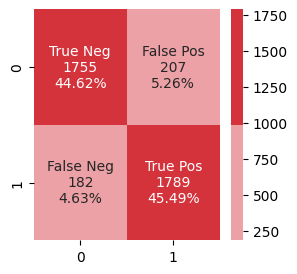

In [ ]:
# select a threshold to drop features using weight or count
# Done: dropping features that occured in over 225 misclassed docs gives over 0.9 accuracy
to_drop = [x[0] for x in word_count.items() if x[1] >= 225]
v = list(vectorizer.get_feature_names_out())
in_v = [x for x in v if x not in to_drop]
print('Length of original vocab set: ', len(v))
print('Length of vocab set to drop: ', len(to_drop))
print('Length of modified vocab set: ', len(in_v))

# create new pipeline with new vectorizer that uses new vocab set
pipeline_feat = Pipeline([('tfidf', TfidfVectorizer(stop_words = list(STOPWORDS), vocabulary=in_v)),
                          ('Logistic', LogisticRegression(random_state = 1))])

# duplicate sets 
x_train3 = np.copy(x_train)
y_train3 = np.copy(y_train)
x_dev3   = np.copy(x_dev)
y_dev3   = np.copy(y_dev)

# run pipe -> vectorizer, predict
pipeline_feat_res = eval(x_train3, y_train3, x_dev3, y_dev3, pipe = pipeline_feat)

# store new results
df_dev = store_res(pipeline_feat_res, 'Logistic-TFIDF-FeatSHAP', overall_result = df_dev)
df_dev

# Tuning Best Model

In [ ]:
# gridsearch and tune logistic regression using previous feature selection method using SHAP
params = {'penalty': ['l1','l2','elasticnet', None],# default is None
          'tol': [0.00001,0.0001, 0.001],                                             # default=1e-4
          'C' : [1,1.5, 2],                                                           # default=1.0
          'solver': ['lbfgs','newton-cg','sag','saga']} # default=’lbfgs’

vectorizer = TfidfVectorizer(stop_words = list(STOPWORDS), vocabulary=in_v)
x_train4 = vectorizer.fit_transform(x_train)
y_train4 = np.copy(y_train)
x_dev4   = vectorizer.transform(x_dev)
y_dev4   = np.copy(y_dev)

gscv = GridSearchCV(LogisticRegression(random_state = 1, max_iter = 200), param_grid = params, scoring = 'accuracy', cv = 2, verbose = 3)
gscv.fit(x_train4, y_train4)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
[CV 1/2] END C=1, penalty=l1, solver=lbfgs, tol=1e-05;, score=nan total time=   0.0s
[CV 2/2] END C=1, penalty=l1, solver=lbfgs, tol=1e-05;, score=nan total time=   0.0s
[CV 1/2] END C=1, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=1, penalty=l1, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=1, penalty=l1, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/2] END C=1, penalty=l1, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/2] END C=1, penalty=l1, solver=newton-cg, tol=1e-05;, score=nan total time=   0.0s
[CV 2/2] END C=1, penalty=l1, solver=newton-cg, tol=1e-05;, score=nan total time=   0.0s
[CV 1/2] END C=1, penalty=l1, solver=newton-cg, tol=0.0001;, score=nan total time=   0.0s
[CV 2/2] END C=1, penalty=l1, solver=newton-cg, tol=0.0001;, score=nan total time=   0.0s
[CV 1/2] END C=1, penalty=l1, solver=newton-cg, tol=0.001;, score=n

GridSearchCV(cv=2, estimator=LogisticRegression(max_iter=200, random_state=1),
             param_grid={'C': [1, 1.5, 2],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                         'tol': [1e-05, 0.0001, 0.001]},
             scoring='accuracy', verbose=3)

In [ ]:
best_model = gscv.best_estimator_
best_params = gscv.best_params_
best_params

{'C': 2, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-05}

,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.500000,1.000000,1.000000,0.000000,0.000000
Pattern-Polarity(0.1),0.764244,0.764322,0.764244,0.764233,15290,4522,4842,15065,0.764262,0.228246,0.756769,0.771754,0.243231
NB-TFIDF,0.872362,0.872766,0.872362,0.872333,1743,219,283,1688,0.872399,0.111621,0.856418,0.888379,0.143582
Logistic-TFIDF,0.898805,0.898965,0.898805,0.898792,1743,219,179,1792,0.898781,0.111621,0.909183,0.888379,0.090817
SVM-Linear-TFIDF,0.895500,0.895534,0.895500,0.895496,1747,215,196,1775,0.895488,0.109582,0.900558,0.890418,0.099442
KNN-TFIDF,0.778286,0.785024,0.778286,0.776914,1374,588,284,1687,0.778108,0.299694,0.855911,0.700306,0.144089
DecisionTree-TFIDF,0.725400,0.725479,0.725400,0.725385,1439,523,557,1414,0.725419,0.266565,0.717402,0.733435,0.282598
RF-TFIDF,0.858886,0.859082,0.858886,0.858872,1707,255,300,1671,0.858912,0.129969,0.847793,0.870031,0.152207
XGB-TFIDF,0.861683,0.861928,0.861683,0.861655,1664,298,246,1725,0.861652,0.151886,0.875190,0.848114,0.124810
Logistic-TFIDF-FeatSHAP,0.901093,0.901155,0.901093,0.901088,1755,207,182,1789,0.901078,0.105505,0.907661,0.894495,0.092339


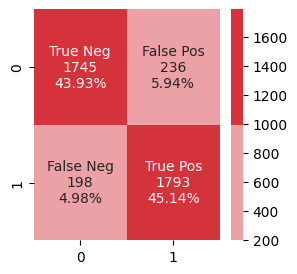

In [ ]:
# how does the model do on train set
pipeline_final = Pipeline([('tfid', TfidfVectorizer(stop_words = list(STOPWORDS), vocabulary=in_v)),
                           ('logistic', LogisticRegression(C=2, penalty='l2',solver='lbfgs',tol=1e-5))])

# run pipe -> vectorizer, predict
pipeline_final_res = eval(x_train, y_train, x_test, y_test, pipe = pipeline_final)

# store new results
df_dev = store_res(pipeline_final_res, 'Logistic-TFIDF-FeatSHAP-Tuned', overall_result = df_dev)
df_dev

,accuracy,precision,recall,f1_score,TN,FP,FN,TP,roc_acc,FPR,TPR,TNR,FNR
ZeroR (Baseline),0.501196,0.251197,0.501196,0.334663,0,19812,0,19907,0.500000,1.000000,1.000000,0.000000,0.000000
Pattern-Polarity(0.1),0.764244,0.764322,0.764244,0.764233,15290,4522,4842,15065,0.764262,0.228246,0.756769,0.771754,0.243231
NB-TFIDF,0.872362,0.872766,0.872362,0.872333,1743,219,283,1688,0.872399,0.111621,0.856418,0.888379,0.143582
Logistic-TFIDF,0.898805,0.898965,0.898805,0.898792,1743,219,179,1792,0.898781,0.111621,0.909183,0.888379,0.090817
SVM-Linear-TFIDF,0.895500,0.895534,0.895500,0.895496,1747,215,196,1775,0.895488,0.109582,0.900558,0.890418,0.099442
KNN-TFIDF,0.778286,0.785024,0.778286,0.776914,1374,588,284,1687,0.778108,0.299694,0.855911,0.700306,0.144089
DecisionTree-TFIDF,0.725400,0.725479,0.725400,0.725385,1439,523,557,1414,0.725419,0.266565,0.717402,0.733435,0.282598
RF-TFIDF,0.858886,0.859082,0.858886,0.858872,1707,255,300,1671,0.858912,0.129969,0.847793,0.870031,0.152207
XGB-TFIDF,0.861683,0.861928,0.861683,0.861655,1664,298,246,1725,0.861652,0.151886,0.875190,0.848114,0.124810
Logistic-TFIDF-FeatSHAP,0.901093,0.901155,0.901093,0.901088,1755,207,182,1789,0.901078,0.105505,0.907661,0.894495,0.092339


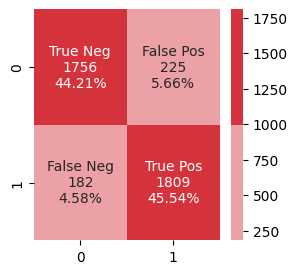

In [ ]:
# how does the model do on the combined train + val test

# combine train and dev sets
x_train = pd.concat([x_train, x_dev], axis = 0)
y_train = pd.concat([y_train, y_dev], axis = 0)

# best params = {'C': 2, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 1e-05}
pipeline_final = Pipeline([('tfid', TfidfVectorizer(stop_words = list(STOPWORDS), vocabulary=in_v)),
                           ('logistic', LogisticRegression(C=2, penalty='l2',solver='lbfgs',tol=1e-5))])

# run pipe -> vectorizer, predict
pipeline_final_res = eval(x_train, y_train, x_test, y_test, pipe = pipeline_final)

# store new results
df_dev = store_res(pipeline_final_res, 'Logistic-Final', overall_result = df_dev)
df_dev

In [ ]:
df_dev.drop('Logistic-Final', inplace = True)

# What about the words that have the most impact, positive or negative?

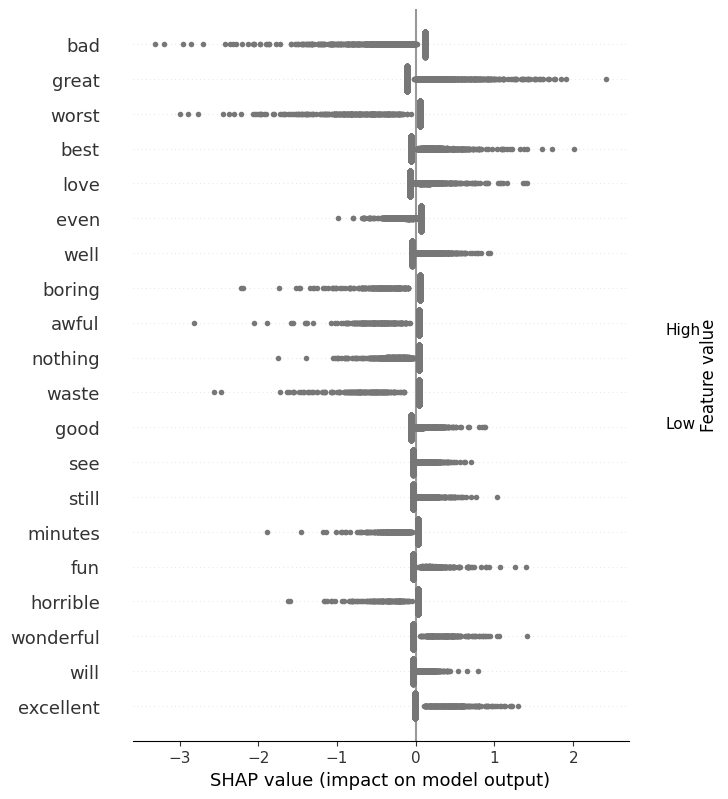

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, x_dev2, feature_names = vectorizer.get_feature_names_out())

In [ ]:
# write out and save the results dataframe
df_dev.to_csv('nlp_res.csv', index = True)
files.download('nlp_res.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>